# Проецирование панорамного снимка на плоскости 3D-модели

In [1]:
# !pip install opencv-python


In [1]:
# !pip install shapely

## Библиотеки

In [1]:
import cv2
import numpy as np
import json
import ast  # Для чтения json
from matplotlib import pyplot as plt

In [2]:
import scipy as sy
from scipy.interpolate import griddata

In [3]:
from shapely.geometry import Point, Polygon

## Функции

In [4]:
# загрузка неправильного json
def load_wall_coordinates(file_path):
    # Используем ast.literal_eval для преобразования строки с одинарными кавычками в строку с двойными кавычками
    with open(file_path, 'r') as json_file:
        data_str = json_file.read()
        data_fixed_quotes = ast.literal_eval(data_str)
    return data_fixed_quotes

In [5]:
# Так не работает
# with open('data/test_object_lu.json', 'r') as json_file:
#         data = json.load(json_file)


In [6]:
def points_between_2_lines(up_line, down_line, in_height, in_width):
    """
        Функция ищет в матрице размером (in_height х in_width) точки между 2 линиями 
    """
    wall_index = []
    for i in range(in_width):  # 1024
        for j in range(in_height):  # 512
            if i < up_line[:, 0].min():
                inside = False
                continue
            elif i > up_line[:, 0].max():
                inside = False
                continue
            elif j <  up_line[:, 1].min():
                inside = False
                continue
            elif j > down_line[:, 1].max():
                inside = False
                continue
            else:
                k = (np.abs((up_line[:, 0] - i))).argmin()  # по х знаем, что попали в индекс
                if (up_line[k, 1] < j) and (j < down_line[k, 1]):
                    wall_index.append((i, j))

    wall_index = np.array(wall_index)    
    
    return wall_index

In [7]:
def get_wall_image(x, y, image, index, wall_height, wall_length, *args, **kwargs):
    """
        Функция для получения интерполированной картинки
    """
    colors = image[index[:, 1], index[:, 0]]
    xt = x[wall_index[:, 1], wall_index[:, 0]]
    yt = y[wall_index[:, 1], wall_index[:, 0]]

    xi, yi = np.meshgrid(
        np.linspace(min(xt), 
                    max(xt), 
                    wall_length), 
        np.linspace(min(yt), 
                   max(yt), 
                   wall_height)
    )

    # Интерполируем значения цвета на равномерной сетке
    zi = griddata((xt, yt), colors, (xi, yi), *args, **kwargs)

    return zi.astype(np.uint8)

In [8]:
def sort_points(points):
    """
        Функция для сортировки точек прямоугольного многоугольника, так, 
        чтобы точки шли по порядку образовывая многоугольник с прямыми углами. 
        Основное условие сортировки - линии образуют прямой угол
    """
    sorted_points = [points[0]]
    points.remove(points[0])

    j = 1
    last = polygon_points[0]
    while len(points) > 0:    
        for point in points:
            if point[j] == last[j]:
                sorted_points.append(point)
                points.remove(point)
                last = point
                if j == 0:
                    j = 1
                else:
                    j = 0

    return sorted_points       

## Загрузка данных

In [9]:
# Загрузка данных
panorama = cv2.imread("data/image_1024_aligned_rgb.png")
floor_plan = cv2.imread("data/floor_plan_test.jpg")
wall_coordinates = load_wall_coordinates("data/test_object_lu.json")
v_corners = np.load("data/v_corners.npy")  # считаем стены строго вертикальными
h_corners = np.load("data/h_corners.npy")
depth_map = np.load("data/depth_map.npy")


In [10]:
wall_coordinates

{'room_id': 0,
 'walls': {0: [0, 0, 0, 2050],
  1: [0, 0, 1640, 0],
  2: [1640, 0, 1640, 400],
  3: [1640, 400, 6020, 400],
  4: [6020, 400, 6020, 2050],
  5: [0, 2050, 6020, 2050]}}

In [11]:
v_corners

array([[  30.914364,  222.41164 ],
       [  30.914364,  298.64883 ],
       [ 363.15613 ,  140.81924 ],
       [ 363.15613 ,  392.54047 ],
       [ 672.78357 ,  149.66058 ],
       [ 672.78357 ,  383.4991  ],
       [ 801.5895  ,  137.09825 ],
       [ 801.5895  ,  396.26495 ],
       [ 845.40314 ,   76.09795 ],
       [ 845.40314 ,  451.50623 ],
       [1008.1279  ,  221.95033 ],
       [1008.1279  ,  299.23853 ]], dtype=float32)

In [12]:
h_corners

array([[221.67708, 221.43863, 221.38431, ..., 222.38773, 223.78665,
        223.0257 ],
       [299.86584, 298.79175, 299.72705, ..., 298.76703, 297.46896,
        299.3693 ]], dtype=float32)

In [13]:
wall_height = 2500

curr_wall = wall_coordinates['walls'][5]
wall_lenght = np.sqrt((curr_wall[0] - curr_wall[2])**2 + (curr_wall[1] - curr_wall[3])**2).astype(int)

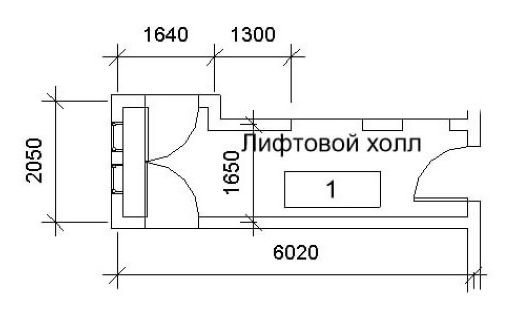

In [14]:
# OpenCV использует порядок цветов BGR, поэтому для корректного отображения в matplotlib
# мы переворачиваем порядок к RGB
# floor_plan_rgb = cv2.cvtColor(floor_plan, cv2.COLOR_BGR2RGB)

# Отображение изображения в Jupyter Notebook
plt.imshow(floor_plan)
plt.axis('off')  # Отключение осей
plt.show()


In [15]:
wall_coordinates

{'room_id': 0,
 'walls': {0: [0, 0, 0, 2050],
  1: [0, 0, 1640, 0],
  2: [1640, 0, 1640, 400],
  3: [1640, 400, 6020, 400],
  4: [6020, 400, 6020, 2050],
  5: [0, 2050, 6020, 2050]}}

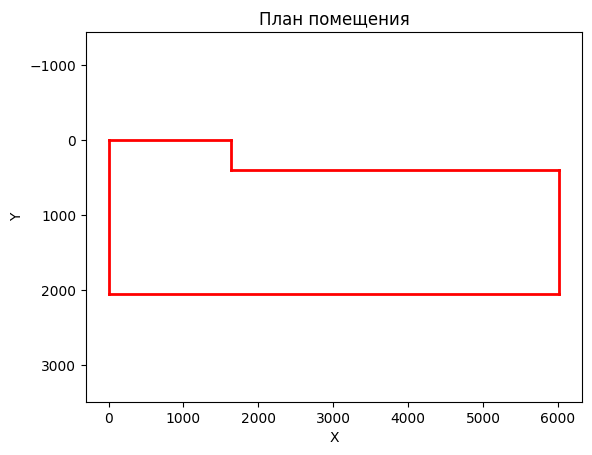

In [16]:
plt.figure()
for wall_id, coordinates in wall_coordinates['walls'].items():
    x1, y1, x3, y3 = coordinates
    plt.plot([x1, x3], [y1, y3], color='red', linewidth=2)

plt.gca().invert_yaxis() 
plt.axis('equal') 
# plt.ylim(3000, 0)

plt.xlabel('X')
plt.ylabel('Y')
plt.title('План помещения')

plt.show()


## Смотрим первую стену

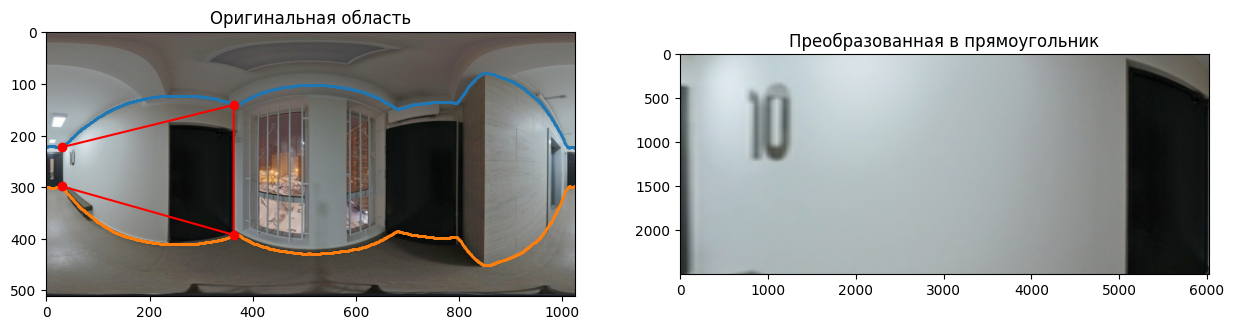

In [17]:
# Заданные 4 точки (координаты x, y)
points = np.vstack([ v_corners[0], v_corners[2], v_corners[3], v_corners[1]])

# Высота стен
wall_height = 2500

curr_wall = wall_coordinates['walls'][5]
wall_length = np.sqrt((curr_wall[0] - curr_wall[2])**2 + (curr_wall[1] - curr_wall[3])**2).astype(int)

rect_width = wall_length
rect_height = wall_height

# Новые координаты для прямоугольника
rect_points = np.array([[0, 0], 
                        [rect_width - 1, 0], 
                        [rect_width - 1, rect_height - 1], 
                        [0, rect_height - 1]], dtype=np.float32)

# Получаем матрицу преобразования
matrix = cv2.getPerspectiveTransform(points, rect_points)

# Применяем аффинное преобразование
transformed_image = cv2.warpPerspective(panorama, matrix, (rect_width, rect_height))

# Отображение оригинальной области и преобразованной в прямоугольник
plt.figure( figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB))
plt.plot(points[:, 0], points[:, 1], 'ro-')

# Наносим границы потолка и пола
xc = list(range(1024))
plt.scatter(xc, h_corners[0], s=1)
plt.scatter(xc, h_corners[1], s=1)
plt.title("Оригинальная область")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(transformed_image, cv2.COLOR_BGR2RGB))
plt.title("Преобразованная в прямоугольник")

plt.show()

# В общем это не то, что надо

#### В общем это не то, что надо

## Перевод панорамы из сферических координат в декартовы

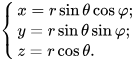

In [18]:
# Радиус сферы
R = 1000

# Получение координат в сферических координатах
phi, theta  = np.meshgrid(np.linspace(0, 2*np.pi, panorama.shape[1]), np.linspace(0, np.pi, panorama.shape[0]))

# Перевод из сферических координат в декартовы
x = R * depth_map * np.sin(theta) * np.cos(phi)
y = R * depth_map * np.sin(theta) * np.sin(phi)
z = R * depth_map * np.cos(theta)


In [19]:
panorama.shape

(512, 1024, 3)

In [20]:
wall_length

6020

## Получаем рисунки стен

In [21]:
# 0
curr_wall = wall_coordinates['walls'][0]
wall_length = np.sqrt((curr_wall[0] - curr_wall[2])**2 + (curr_wall[1] - curr_wall[3])**2).astype(int)

ci = 2
x1 = int(v_corners[ci][0]) + 1
x2 = int(v_corners[ci+2][0]) + 1

up_line = np.stack((np.arange(x1, x2), h_corners[0, x1: x2]), axis=1)
down_line = np.stack((np.arange(x1, x2), h_corners[1, x1: x2]), axis=1)

wall_index = points_between_2_lines(up_line, down_line, 512, 1024)

zi_uint8 = get_wall_image(-y, z, panorama, wall_index, wall_height, wall_length, method='linear')

cv2.imwrite("0_proj.jpg", zi_uint8)

True

In [22]:
# 1
curr_wall = wall_coordinates['walls'][1]
wall_length = np.sqrt((curr_wall[0] - curr_wall[2])**2 + (curr_wall[1] - curr_wall[3])**2).astype(int)

ci = 4
x1 = int(v_corners[ci][0]) + 1
x2 = int(v_corners[ci+2][0]) + 1

up_line = np.stack((np.arange(x1, x2), h_corners[0, x1: x2]), axis=1)
down_line = np.stack((np.arange(x1, x2), h_corners[1, x1: x2]), axis=1)

wall_index = points_between_2_lines(up_line, down_line, 512, 1024)

zi_uint8 = get_wall_image(x, -z, panorama, wall_index, wall_height, wall_length, method='linear')

cv2.imwrite("1_proj.jpg", zi_uint8)

True

In [23]:
# 2
curr_wall = wall_coordinates['walls'][2]
wall_length = np.sqrt((curr_wall[0] - curr_wall[2])**2 + (curr_wall[1] - curr_wall[3])**2).astype(int)

ci = 6

x1 = int(v_corners[ci][0]) + 1
x2 = int(v_corners[ci+2][0]) + 1

up_line = np.stack((np.arange(x1, x2), h_corners[0, x1: x2]), axis=1)
down_line = np.stack((np.arange(x1, x2), h_corners[1, x1: x2]), axis=1)

wall_index = points_between_2_lines(up_line, down_line, 512, 1024)

zi_uint8 = get_wall_image(y, z, panorama, wall_index, wall_height, wall_length, method='nearest')

cv2.imwrite("2_proj.jpg", zi_uint8)
#y

True

In [24]:
# 3
curr_wall = wall_coordinates['walls'][3]
wall_length = np.sqrt((curr_wall[0] - curr_wall[2])**2 + (curr_wall[1] - curr_wall[3])**2).astype(int)

ci = 8

x1 = int(v_corners[ci][0]) + 1
x2 = int(v_corners[ci+2][0]) + 1

up_line = np.stack((np.arange(x1, x2), h_corners[0, x1: x2]), axis=1)
down_line = np.stack((np.arange(x1, x2), h_corners[1, x1: x2]), axis=1)

wall_index = points_between_2_lines(up_line, down_line, 512, 1024)

zi_uint8 = get_wall_image(x, -z, panorama, wall_index, wall_height, wall_length, method='linear')

cv2.imwrite("3_proj.jpg", zi_uint8)
#x

True

In [25]:
# 4
curr_wall = wall_coordinates['walls'][4]
wall_length = np.sqrt((curr_wall[0] - curr_wall[2])**2 + (curr_wall[1] - curr_wall[3])**2).astype(int)

ci = 10

x1 = int(v_corners[ci][0]) + 1
x2 = 1024

up_line = np.stack((np.arange(x1, x2), h_corners[0, x1: x2]), axis=1)
down_line = np.stack((np.arange(x1, x2), h_corners[1, x1: x2]), axis=1)
wall_index1 = points_between_2_lines(up_line, down_line, 512, 1024)

x1 = 0
x2 = int(v_corners[0][0]) + 1

up_line = np.stack((np.arange(x1, x2), h_corners[0, x1: x2]), axis=1)
down_line = np.stack((np.arange(x1, x2), h_corners[1, x1: x2]), axis=1)

wall_index2 = points_between_2_lines(up_line, down_line, 512, 1024)
wall_index = np.vstack((wall_index1, wall_index2))

zi_uint8 = get_wall_image(y, -z, panorama, wall_index, wall_height, wall_length, method='linear')

cv2.imwrite("4_proj.jpg", zi_uint8)
#y

True

In [27]:
# 5

curr_wall = wall_coordinates['walls'][5]
wall_length = np.sqrt((curr_wall[0] - curr_wall[2])**2 + (curr_wall[1] - curr_wall[3])**2).astype(int)

x1 = int(v_corners[0][0]) + 1
x2 = int(v_corners[2][0]) + 1

up_line = np.stack((np.arange(x1, x2), h_corners[0, x1: x2]), axis=1)
down_line = np.stack((np.arange(x1, x2), h_corners[1, x1: x2]), axis=1)

wall_index = points_between_2_lines(up_line, down_line, 512, 1024)

zi_uint8 = get_wall_image(-x, -z, panorama, wall_index, wall_height, wall_length, method='linear')

cv2.imwrite("5_proj.jpg", zi_uint8)

True

In [28]:
# ceil
wall_index = []
for i in range(1024):
    for j in range(512):
        if j < h_corners[0][i]:
            wall_index.append((i, j))

wall_index = np.array(wall_index)   

zi_uint8 = get_wall_image(x, y, panorama, wall_index, 2050, 6020, method='nearest')

polygon_lines = wall_coordinates['walls']
polygon_points = []
for line_coords in polygon_lines.values():
        polygon_points.extend([(line_coords[0], line_coords[1]), (line_coords[2], line_coords[3])])
polygon_points = list(set(polygon_points))    
sorted_points = sort_points(polygon_points)

image = zi_uint8*255
mask = np.zeros_like(image)
cv2.fillPoly(mask, [np.array(sorted_points, dtype=np.int32)], (255, 255, 255))
image = zi_uint8*255
result = cv2.bitwise_xor(image, mask)
result = cv2.bitwise_and(result, mask)

cv2.imwrite("ceil_proj.jpg", result)

True

In [29]:
# floor
wall_index = []
for i in range(1024):
    for j in range(512):
        if j > h_corners[1][i]:
            wall_index.append((i, j))

wall_index = np.array(wall_index)   

zi_uint8 = get_wall_image(x, y, panorama, wall_index, 2050, 6020, method='nearest')

polygon_lines = wall_coordinates['walls']
polygon_points = []
for line_coords in polygon_lines.values():
        polygon_points.extend([(line_coords[0], line_coords[1]), (line_coords[2], line_coords[3])])
polygon_points = list(set(polygon_points))    
sorted_points = sort_points(polygon_points)

image = zi_uint8*255
mask = np.zeros_like(image)
cv2.fillPoly(mask, [np.array(sorted_points, dtype=np.int32)], (255, 255, 255))
image = zi_uint8*255
result = cv2.bitwise_xor(image, mask)
result = cv2.bitwise_and(result, mask)

cv2.imwrite("floor_proj.jpg", result)

True

## Немного того, что было  "за кадром"

### Внимание! Код ниже не работает!


**Координаты потолка**

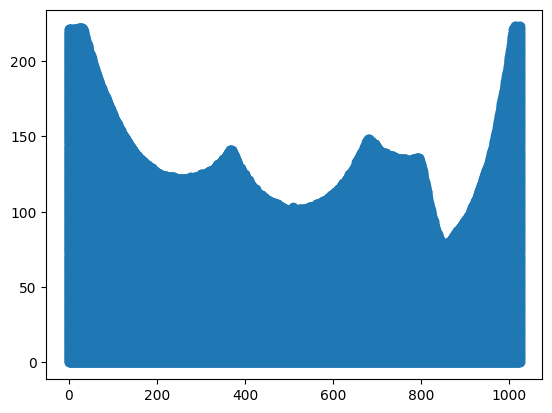

In [167]:
plt.scatter(wall_index[:, 0], wall_index[:, 1] )

**Потолок в декартовых координатах без интерполяции**

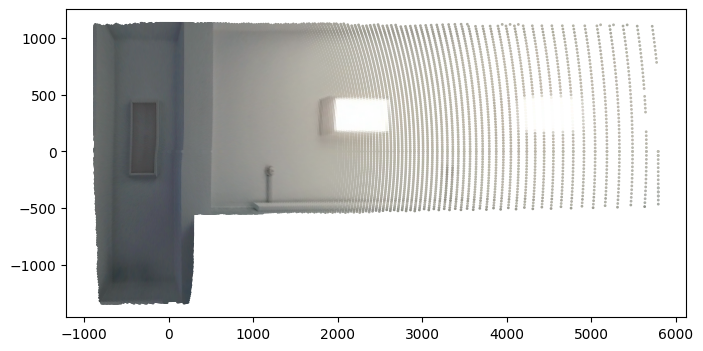

In [229]:
plt.figure(figsize=(8, 4))
plt.scatter(v_axis, zt, s=1, c=tst/255)

# plt.imshow(bgr_image)

plt.show()

**Потолок с интерполяцией**

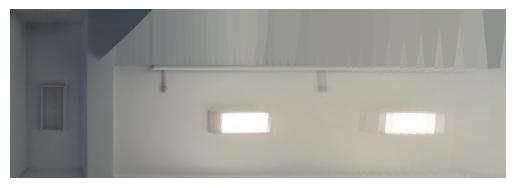

In [235]:
# Отображаем результат
# plt.figure(figsize=(8, 4))
# plt.imshow(zi, extent=(min(-xt), max(-xt), min(zt), max(zt)), origin='lower', cmap='viridis')
# plt.imshow(zi, extent=(0, 6020, 0, 2500), origin='lower', cmap='viridis')
plt.imshow(zi, extent=(0, wall_length, 0, wall_height), origin='lower')
# plt.imshow(zi, origin='lower')
plt.gca().invert_yaxis() 

plt.axis('off') 

plt.savefig('test wall.png', dpi=300, format='png')
plt.show()

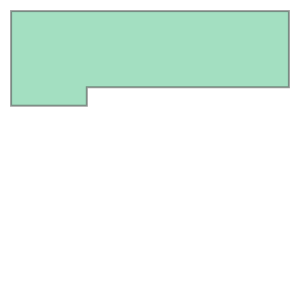

In [331]:
polygon

**Как найти стены? Как вариант не по заданной линии а по скоплению точек у какой-то плоскости**

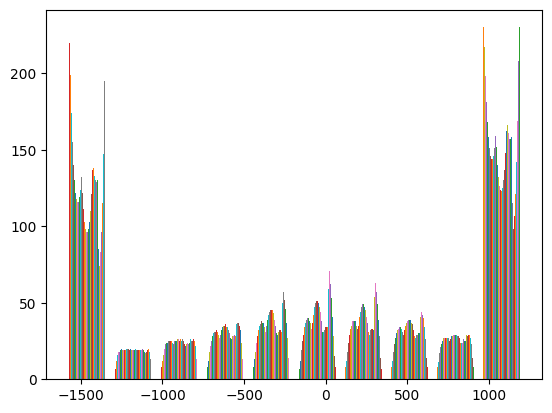

In [18]:
plt.hist(z)
plt.show()

In [39]:
idx = (z<100) & (z > -100)

**Про ориентацию и расположение стен ничего не сказано.** 

При решении принимал за основу факт, что на всех рисунках порядок стен будет аналогичная. Но если ориентация произвольная, то можно по сечению середины можно оценить расположение в пространстве.

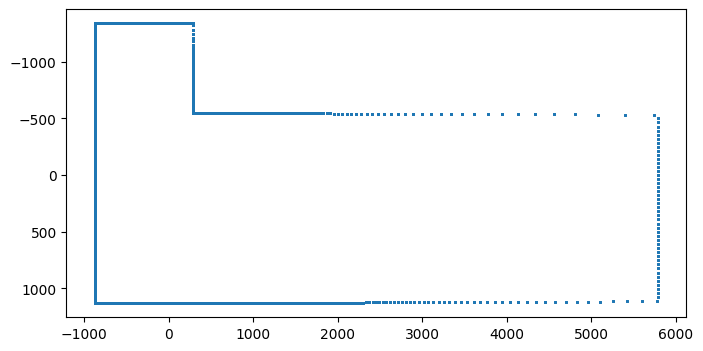

In [40]:


plt.figure(figsize=(8, 4))
plt.scatter(x[idx], y[idx], s=1)

plt.gca().invert_yaxis() 

# plt.imshow(bgr_image)

plt.show()

**Пробовал найти готовые решения в интернете, но это немного не то. Хотя как вариант тоже наверно можно адаптировать**

In [350]:
!pip install py360convert

Defaulting to user installation because normal site-packages is not writeable
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for py360convert: filename=py360convert-0.1.0-py3-none-any.whl size=8180 sha256=8933dc91c4a26d186c519ffa07af71fa3b8a8c1c64eff28f21f7adaafcee2efb
  Stored in directory: c:\users\lenovo\appdata\local\pip\cache\wheels\0e\42\6a\bf52938eafb50a313716d883f62982b5b5a3f909b74b64563a
Successfully built py360convert


In [351]:
import py360convert as py360

In [357]:
out_p = py360.e2c(e_img=panorama)

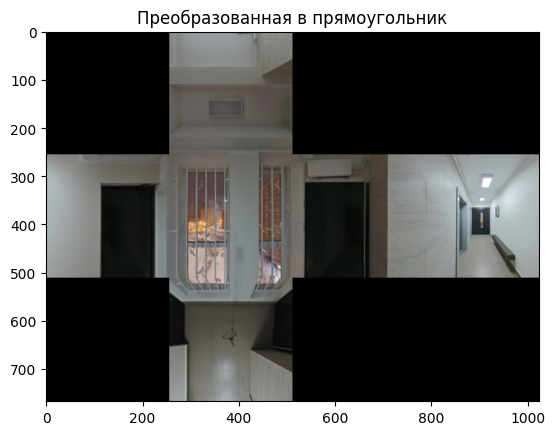

In [358]:
plt.imshow(cv2.cvtColor(out_p, cv2.COLOR_BGR2RGB))
plt.title("Преобразованная в прямоугольник")

plt.show()